### Tensorflow Regression for Predicting Ni

In [1]:
import pathlib
import pandas as pd
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

###### Import the dataset

In [3]:
dataset_path = r'C:\Users\v.t.flores\Documents\ZnNi_project_2015_2020_dataset.xlsx'

raw_dataset = pd.read_excel(dataset_path)
dataset = raw_dataset.set_index('DATETIME')

for col in dataset.columns:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')
dataset.interpolate(method='linear', limit_direction = 'forward', inplace=True)

###### Clean the data

In [4]:
# Zn is not included in this list for the zn prediction at 106TK01
columns_include = ['104_Al', '104_Ca', '104_Co', '104_Cr', '104_Cu', '104_Fe', '104_Fe2',
       '104_Ft', '104_Mg', '104_Mn', '104_NTU', '104_Ni', '104_ORP', '104_Pb',
       '104_Si', '104_Zn', '104_pH60', 'DeZn_Feed_Flow', 'DeZn_Feed_T',
       'H2S_tk01', 'H2S_tk02', '106_Ni', 'tk05_Al', 'tk05_Ca',
       'tk05_Co', 'tk05_Cr', 'tk05_Cu', 'tk05_Fe', 'tk05_Mg', 'tk05_Mn',
       'tk05_Ni', 'tk05_Pb', 'tk05_Si', 'tk05_Zn', 'DeZn_TK05_T']
print(len(columns_include))

35


In [5]:
dataset = dataset[columns_include] # select only the parameters that we're interested in
dataset = dataset.drop(dataset.loc['2020-08-01 00:00:00':'2020-09-27 10:00:00'].index) # remove the august and september2020 data to prior to training

In [6]:
print(dataset.columns)
print(len(dataset.columns))

Index(['104_Al', '104_Ca', '104_Co', '104_Cr', '104_Cu', '104_Fe', '104_Fe2',
       '104_Ft', '104_Mg', '104_Mn', '104_NTU', '104_Ni', '104_ORP', '104_Pb',
       '104_Si', '104_Zn', '104_pH60', 'DeZn_Feed_Flow', 'DeZn_Feed_T',
       'H2S_tk01', 'H2S_tk02', '106_Ni', 'tk05_Al', 'tk05_Ca', 'tk05_Co',
       'tk05_Cr', 'tk05_Cu', 'tk05_Fe', 'tk05_Mg', 'tk05_Mn', 'tk05_Ni',
       'tk05_Pb', 'tk05_Si', 'tk05_Zn', 'DeZn_TK05_T'],
      dtype='object')
35


###### Split data into train and test

In [7]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

###### Inspect the data

In [8]:
# Also look at the overall statistics:

train_stats = train_dataset.describe()
train_stats.pop('106_Ni')
train_stats = train_stats.transpose()

##### Split features from labels

In [9]:
#Separate the target value, or "label", from the features. 
#This label is the value that you will train the model to predict.

train_labels = train_dataset.pop('106_Ni')
#train_labels = train_labels.pop('106_Zn')

In [10]:
test_labels = test_dataset.pop('106_Ni')
#test_labels = test_labels.pop('106_Zn')

In [11]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [12]:
normed_train_data.columns
#normed_test_data

Index(['104_Al', '104_Ca', '104_Co', '104_Cr', '104_Cu', '104_Fe', '104_Fe2',
       '104_Ft', '104_Mg', '104_Mn', '104_NTU', '104_Ni', '104_ORP', '104_Pb',
       '104_Si', '104_Zn', '104_pH60', 'DeZn_Feed_Flow', 'DeZn_Feed_T',
       'H2S_tk01', 'H2S_tk02', 'tk05_Al', 'tk05_Ca', 'tk05_Co', 'tk05_Cr',
       'tk05_Cu', 'tk05_Fe', 'tk05_Mg', 'tk05_Mn', 'tk05_Ni', 'tk05_Pb',
       'tk05_Si', 'tk05_Zn', 'DeZn_TK05_T'],
      dtype='object')

#### The model

In [13]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [14]:
model = build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
# Use the .summary method to print a simple description of the model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2240      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


In [79]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.01018   ],
       [ 0.2941139 ],
       [-1.1650108 ],
       [ 0.22694859],
       [ 0.12691769],
       [ 0.40898204],
       [ 0.27929056],
       [ 0.39275897],
       [-0.1176441 ],
       [ 0.18210927]], dtype=float32)

In [80]:
# the array should display 10 values representing the Zn predictions

##### Train the model

In [82]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,9.570808e-07,0.000665,9.570806e-07,0.000002,0.000997,0.000002,995
996,9.558616e-07,0.000667,9.558622e-07,0.000001,0.000705,0.000001,996
997,9.320324e-07,0.000660,9.320325e-07,0.000001,0.000620,0.000001,997
998,8.926259e-07,0.000654,8.926264e-07,0.000002,0.000879,0.000002,998
999,9.594742e-07,0.000656,9.594738e-07,0.000002,0.000974,0.000002,999


In [21]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Zn_drop]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
            label= 'Val Error')
    plt.legend()
    plt.ylim([-1, 1])
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [Zn_drop]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
            label= 'Val Error')
    plt.legend()
    plt.ylim([-1, 1])
    
        

In [22]:
import matplotlib.pyplot as plt

NameError: name 'history' is not defined

In [24]:
model = build_model()


................................

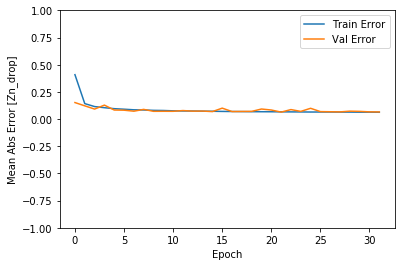

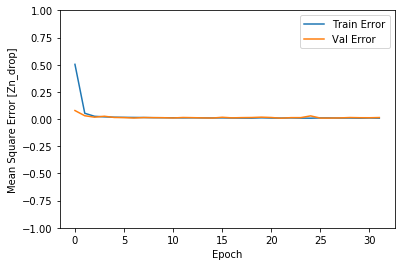

In [25]:
# The patience parameter is the amount of epochs to check for improvement
EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [27]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

6067/6067 - 0s - loss: 0.0088 - mean_absolute_error: 0.0639 - mean_squared_error: 0.0088


In [28]:

print("Testing set Mean Abs Error: {:5.2f} Ni".format(mae))

Testing set Mean Abs Error:  0.06 Ni


In [29]:
test_predictions = model.predict(normed_test_data).flatten()

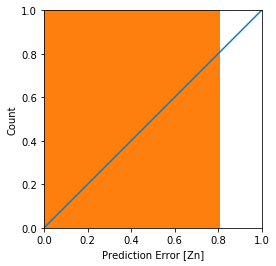

In [30]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [106]')
plt.ylabel('Predictions [106]')

lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Ni]")
_ = plt.ylabel("Count")

In [31]:
model.save(r'C:\Users\v.t.flores\Documents\Ni_TF_model1')

#new_model = tf.keras.models.load_model(r'C:\Users\v.t.flores\Documents\Zn_drop_TF_model')

#print(new_model.predict(test_images).shape)